<a href="https://colab.research.google.com/github/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [33]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device('cpu', 0)

# Load Dataset

In [7]:
data_dir='./results/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
filenames
# Creating a function to read the txt Files
# This function returns all the lines in the txt file as a list
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()
# Preprocessing Functions
# Returns a list of dictionaries of abstract's lines
# Dict Format --> {'TARGET':'Background/Results/Objetive/Concludion','Text':'The actual statement'}
def preprocess_data(filename):
    input_lines=get_lines(filename)
    #This will be used to separte the abstracts from  one another using String mets
    abstract_lines=""
    # Empty list of abstracts
    abstract_samples=[]
    for line in input_lines:
        # Check for a new abstract
        if line.startswith("###"):
            abstract_id=line
            # And since we are in a new abstract we will Reset the abstract_lines
            abstract_lines=""
        # Check for a new line \n escape seq
        elif line.isspace():
            # Split the Lines of the abstract and will return a list of one abstract
            abstract_line_split=abstract_lines.splitlines()
            # Now we have to iterate through this singular abstract
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                #  Enumerate() method adds a counter to an iterable and returns it in a form of enumerating object.
                # Create a empty Dict per line
                line_data={}
                # Split on the tab \t esc seq
                target_text_split=abstract_line.split("\t")
                # Get the Label of the sentence as the Label
                line_data["target"]=target_text_split[0]
                # Get the Text of the Lien as the Text Key
                line_data["text"]=target_text_split[1].lower()
                # Also adding the Line Nnumber as it will also aid the model
                line_data["line_number"]=abstract_line_number
                # Number of Lines in that particular abstract
                line_data["total_lines"]=len(abstract_line_split)-1
                # Now we have to append them to the absract_samples list
                abstract_samples.append(line_data)
        # So if both the cases are not there then the line is a labelled sentence
        else:
            abstract_lines+=line
    return abstract_samples

# Get the data and preprocess it
train_samples=preprocess_data(data_dir+"train.txt")
val_samples=preprocess_data(data_dir+"dev.txt")
test_samples=preprocess_data(data_dir+"test.txt")
df=pd.DataFrame(train_samples+val_samples+test_samples)

In [88]:
# df = pd.read_csv("spamdata_v2.csv")
df.head()
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)

In [89]:
df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [4]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [10]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['target'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [11]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading: 100%|███████████████████████████████████████| 570/570 [00:00<00:00, 90.4kB/s]
Downloading: 100%|██████████████████████████████████████| 420M/420M [08:25<00:00, 871kB/s]
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequ

In [12]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [13]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<AxesSubplot:>

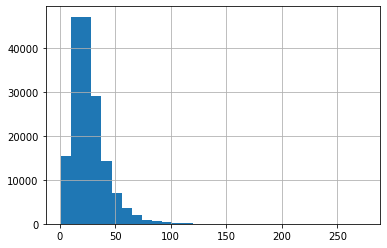

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [15]:
max_seq_len = 25

In [25]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_df["text"].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_df["text"].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_df["text"].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [96]:
labels = ['OBJECTIVE', 'METHODS', 'BACKGROUND', 'CONCLUSIONS', 'RESULTS']
train_y = torch.tensor([labels.index(x) for x in train_df["target"].tolist()])
test_y = torch.tensor([labels.index(x) for x in test_df["target"].tolist()])
val_y = torch.tensor([labels.index(x) for x in val_df["target"].tolist()])

# Convert Integer Sequences to Tensors

In [97]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

# Create DataLoaders

In [98]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [99]:
train_data[0]

(tensor([  101,  2000,  8556,  1996, 21150,  1997,  1030,  3134,  1997,  3679,
          2659,  1011, 13004,  8700,  3653,  2094,  8977, 12898,  2638,  1999,
          9229,  3255,  1010, 12969,   102]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]),
 tensor(0))

# Freeze BERT Parameters

In [100]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [101]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,5)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      print(cls_hs)
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [102]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [103]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights

In [104]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[1.66951086 1.32365782 0.6069361  2.59215898 0.62029306]


In [105]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [106]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [109]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
tensor([[-0.8156, -0.4171, -0.6993,  ..., -0.4400, -0.6103,  0.7291],
        [-0.6199, -0.2785, -0.7281,  ..., -0.5725, -0.5219,  0.4833],
        [-0.8130, -0.1766, -0.6479,  ..., -0.6792, -0.5201,  0.6284],
        ...,
        [-0.6496, -0.4285, -0.8490,  ..., -0.7686, -0.6729,  0.6417],
        [-0.7770, -0.3329, -0.1552,  ..., -0.3705, -0.5613,  0.7064],
        [-0.4765, -0.2421, -0.4291,  ..., -0.7028, -0.3866,  0.2383]])
tensor([[-0.8401, -0.3599, -0.6785,  ..., -0.6193, -0.6134,  0.7208],
        [-0.6879, -0.1740, -0.3605,  ..., -0.5798, -0.3563,  0.3593],
        [-0.8494, -0.3447, -0.9682,  ..., -0.9690, -0.6484,  0.7556],
        ...,
        [-0.9146, -0.3434, -0.5750,  ..., -0.6575, -0.5975,  0.8022],
        [-0.8766, -0.4583, -0.5630,  ..., -0.4035, -0.7459,  0.8205],
        [-0.4180,  0.0651,  0.4078,  ...,  0.2397, -0.3067,  0.5243]])
tensor([[-0.6799, -0.1512, -0.4256,  ..., -0.3917, -0.6052,  0.6231],
        [-0.8524, -0.1493,  0.0754,  ..., -0.54

tensor([[-0.8648, -0.2712, -0.5434,  ..., -0.6296, -0.5825,  0.8704],
        [-0.5463, -0.3320, -0.6489,  ..., -0.5890, -0.5759,  0.5339],
        [-0.8710, -0.2094, -0.7069,  ..., -0.6886, -0.6217,  0.7664],
        ...,
        [-0.7019, -0.1161,  0.3272,  ...,  0.0184, -0.4347,  0.6721],
        [-0.7944, -0.3639, -0.8513,  ..., -0.7997, -0.6113,  0.5371],
        [-0.9168, -0.2647, -0.8210,  ..., -0.7052, -0.6365,  0.8807]])
tensor([[-0.5041, -0.1895, -0.4161,  ..., -0.3612, -0.4398,  0.4262],
        [-0.5868, -0.0557,  0.1053,  ..., -0.3141, -0.4661,  0.4660],
        [-0.7217, -0.1679, -0.1820,  ..., -0.4419, -0.4274,  0.3689],
        ...,
        [-0.9164, -0.5956, -0.9791,  ..., -0.9328, -0.7226,  0.7804],
        [-0.7398, -0.3048, -0.5518,  ..., -0.5789, -0.6053,  0.7071],
        [-0.6577, -0.1026, -0.5516,  ..., -0.3804, -0.4558,  0.3757]])
tensor([[-0.7182, -0.2412, -0.6624,  ..., -0.4169, -0.5819,  0.5239],
        [-0.7726, -0.4389, -0.5106,  ..., -0.3421, -0.6308,  0

tensor([[-0.8179, -0.2867, -0.7245,  ..., -0.7839, -0.6258,  0.6949],
        [-0.7614, -0.0301, -0.3248,  ..., -0.8040, -0.4131,  0.5618],
        [-0.8881, -0.4083, -0.9133,  ..., -0.8524, -0.6604,  0.7868],
        ...,
        [-0.6973, -0.2974, -0.7218,  ..., -0.6014, -0.5148,  0.3930],
        [-0.5359, -0.2039, -0.7528,  ..., -0.7519, -0.5072,  0.5007],
        [-0.8016, -0.2442, -0.8350,  ..., -0.7297, -0.6003,  0.6764]])
tensor([[-0.8064, -0.4227, -0.8653,  ..., -0.7880, -0.6676,  0.5925],
        [-0.8634, -0.2667, -0.3771,  ..., -0.2272, -0.6338,  0.7314],
        [-0.8613, -0.3065, -0.7860,  ..., -0.8427, -0.5399,  0.8322],
        ...,
        [-0.7557, -0.2064, -0.2076,  ..., -0.3467, -0.6149,  0.5876],
        [-0.6424, -0.0417,  0.3994,  ...,  0.0269, -0.4336,  0.5392],
        [-0.7479, -0.2306, -0.5478,  ..., -0.7122, -0.4872,  0.7263]])
tensor([[-0.8936, -0.4073, -0.5891,  ..., -0.7436, -0.5648,  0.6423],
        [-0.7699, -0.3362, -0.8332,  ..., -0.7701, -0.7445,  0

tensor([[-0.9542, -0.4160, -0.6578,  ..., -0.8474, -0.6455,  0.8118],
        [-0.3529,  0.0412, -0.0781,  ..., -0.2069, -0.2196,  0.0849],
        [-0.9031, -0.3059, -0.6364,  ..., -0.4235, -0.6051,  0.7595],
        ...,
        [-0.7770, -0.3082, -0.6268,  ..., -0.5094, -0.6543,  0.7854],
        [-0.7497, -0.2155,  0.0254,  ..., -0.1501, -0.5505,  0.6210],
        [-0.8722, -0.4490, -0.9191,  ..., -0.9044, -0.6578,  0.7812]])
tensor([[-0.7375, -0.2948, -0.6687,  ..., -0.5865, -0.6614,  0.7894],
        [-0.7732, -0.2636, -0.4525,  ..., -0.4171, -0.5265,  0.5878],
        [-0.2895,  0.2911,  0.9006,  ...,  0.5366, -0.2379,  0.4128],
        ...,
        [-0.8784, -0.4812, -0.8752,  ..., -0.7333, -0.6756,  0.9034],
        [-0.8651, -0.3795, -0.9177,  ..., -0.7522, -0.6376,  0.6215],
        [-0.6102, -0.1883, -0.4002,  ..., -0.6814, -0.4930,  0.4822]])
tensor([[-0.8287, -0.3806, -0.8350,  ..., -0.8827, -0.6347,  0.7647],
        [-0.7390, -0.2814, -0.0588,  ..., -0.2339, -0.5102,  0

tensor([[-0.6615, -0.2896, -0.6864,  ..., -0.7097, -0.5845,  0.6792],
        [-0.7257, -0.0984, -0.4752,  ..., -0.4181, -0.4234,  0.5903],
        [-0.8003, -0.2852, -0.7437,  ..., -0.4843, -0.6359,  0.7060],
        ...,
        [-0.8113, -0.2062, -0.1968,  ..., -0.4182, -0.4944,  0.6318],
        [-0.7921,  0.0244, -0.6001,  ..., -0.8199, -0.5064,  0.5785],
        [-0.8489, -0.6387, -0.9640,  ..., -0.8769, -0.7258,  0.8465]])
tensor([[-0.6417, -0.2641, -0.7700,  ..., -0.7737, -0.4266,  0.5337],
        [-0.7408, -0.2053, -0.5122,  ..., -0.5340, -0.5167,  0.6214],
        [-0.7548, -0.1250,  0.1021,  ...,  0.0689, -0.5158,  0.7018],
        ...,
        [-0.9616, -0.2966,  0.4063,  ..., -0.3513, -0.4022,  0.9235],
        [-0.6025, -0.1954, -0.5262,  ..., -0.5367, -0.5104,  0.5751],
        [-0.7324, -0.2197, -0.3670,  ..., -0.4926, -0.4538,  0.5870]])
tensor([[-0.7298, -0.2574, -0.4331,  ..., -0.4289, -0.4378,  0.6720],
        [-0.7862, -0.2982, -0.5450,  ..., -0.2064, -0.6253,  0

tensor([[-0.9062, -0.4115, -0.8471,  ..., -0.7076, -0.6850,  0.7489],
        [-0.7477, -0.0778, -0.0734,  ..., -0.4204, -0.4736,  0.5613],
        [-0.9090, -0.3678, -0.2768,  ..., -0.5272, -0.5846,  0.8066],
        ...,
        [-0.7553, -0.2419, -0.1300,  ..., -0.3385, -0.5185,  0.5134],
        [-0.7344, -0.2231, -0.2545,  ..., -0.1961, -0.6180,  0.6651],
        [-0.9105, -0.5796, -0.9594,  ..., -0.8703, -0.7633,  0.7836]])
tensor([[-0.7459, -0.1696, -0.6216,  ..., -0.6929, -0.5678,  0.6385],
        [-0.8322, -0.3868, -0.8476,  ..., -0.8532, -0.5915,  0.5740],
        [-0.7126, -0.2992, -0.5457,  ..., -0.5818, -0.5043,  0.5392],
        ...,
        [-0.4576, -0.0831, -0.1609,  ..., -0.1151, -0.4191,  0.2805],
        [-0.8870, -0.4419, -0.7830,  ..., -0.8371, -0.6106,  0.7921],
        [-0.4599, -0.3332, -0.8738,  ..., -0.7276, -0.5693,  0.5845]])
tensor([[-0.7714, -0.4243, -0.8626,  ..., -0.7957, -0.6251,  0.7723],
        [-0.7677, -0.3730, -0.6034,  ..., -0.5884, -0.6679,  0

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# Get Predictions for Test Data

In [25]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [26]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       724
           1       0.88      0.92      0.90       112

    accuracy                           0.97       836
   macro avg       0.93      0.95      0.94       836
weighted avg       0.97      0.97      0.97       836



In [27]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,710,14
1,9,103
